In [ ]:
!pip install scikit-image



In [ ]:
from google.colab import files
from PIL import Image, ImageFilter
import io

uploaded = files.upload()
img_name = list(uploaded.keys())[0]


Saving 7_NIKON-D3400-35MM_F.JPG to 7_NIKON-D3400-35MM_F.JPG


In [ ]:
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

# Load & blur
img = Image.open(img_name).convert('RGB').resize((128, 128))
blurred = img.filter(ImageFilter.GaussianBlur(radius=2))

# Convert to tensors and numpy
transform = transforms.ToTensor()
original_np = np.array(img).astype(np.float32) / 255.
blurred_np = np.array(blurred).astype(np.float32) / 255.
blurred_tensor = transform(blurred).unsqueeze(0)


In [ ]:
import torch
import torch.nn as nn

class DIPNetwork(nn.Module):
    def __init__(self):
        super(DIPNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 3, 1)
        )
    def forward(self, x):
        return self.net(x)


In [ ]:
model = DIPNetwork()
input_noise = torch.randn(1, 32, 128, 128, requires_grad=True)
optimizer = torch.optim.Adam([input_noise], lr=0.01)
loss_fn = nn.MSELoss()

for i in range(1000):
    output = model(input_noise)
    loss = loss_fn(output, blurred_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        print(f"Iteration {i}, Loss: {loss.item():.6f}")


Iteration 0, Loss: 0.244487
Iteration 100, Loss: 0.128146
Iteration 200, Loss: 0.067304
Iteration 300, Loss: 0.033086
Iteration 400, Loss: 0.015610
Iteration 500, Loss: 0.007164
Iteration 600, Loss: 0.003229
Iteration 700, Loss: 0.001436
Iteration 800, Loss: 0.000631
Iteration 900, Loss: 0.000274


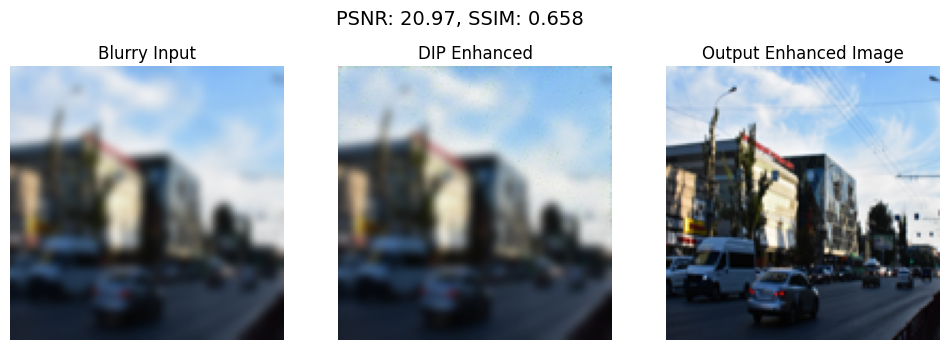

In [ ]:
with torch.no_grad():
    output_np = output.squeeze().permute(1, 2, 0).numpy()

psnr_score = psnr(original_np, output_np)
ssim_score = ssim(original_np, output_np, channel_axis=2,data_range=1.0)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(blurred_np)
plt.title("Blurry Input")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(output_np)
plt.title("DIP Enhanced")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(original_np)
plt.title("Output Enhanced Image")
plt.axis("off")

plt.suptitle(f"PSNR: {psnr_score:.2f}, SSIM: {ssim_score:.3f}", fontsize=14)
plt.show()
